In [2]:
import pandas as pd
import seaborn as sns

In [3]:
def readFileAsArr(fileName, source):
    res = []
    file = open('/home/brgverst/benchres/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [4]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'latency (ms)'])

In [5]:
df.groupby(["Platform"]).describe()


latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10100.0  2.420577  2.878634  1.291234  2.051407  2.208203   
Dapr          10100.0  2.688424  3.005104  1.727504  2.275340  2.438318   
Plumber       10100.0  2.943450  3.206573  1.846369  2.496495  2.668490   

                                
               75%         max  
Platform                        
Baseline  2.380590  128.037175  
Dapr      2.643198  128.789914  
Plumber   2.878328  128.102657

In [6]:
df.head()

,Platform,Begin nano,End nano,latency (ms)
0,Plumber,1628625550491174453,1628625550493778025,2.603572
1,Plumber,1628625550592228179,1628625550594705875,2.477696
2,Plumber,1628625550693194825,1628625550695922847,2.728022
3,Plumber,1628625550794203310,1628625550796538664,2.335354
4,Plumber,1628625550894937937,1628625550898299936,3.361999


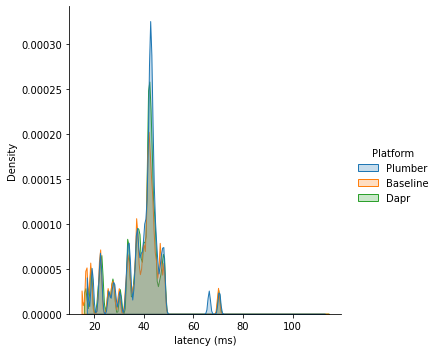

In [7]:
sns.displot(df, x="latency (ms)", hue="Platform", kind="kde", fill=True, cut=-30)

<AxesSubplot:xlabel='latency (ms)', ylabel='Proportion'>

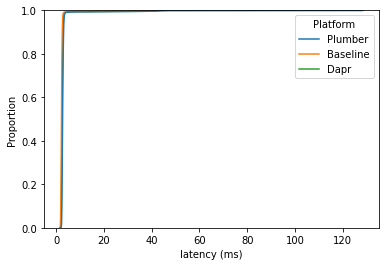

In [8]:
sns.ecdfplot(data=df, x="latency (ms)", hue="Platform")

In [10]:
df.shape

(30300, 4)

In [21]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["latency (ms)"]
    q3 = df_plat.quantile(0.75)["latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(plat_filtered.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(10100, 4)
(9895, 4)
Baseline
(10100, 4)
(9895, 4)
Dapr
(10100, 4)
(9895, 4)


<ipython-input-21-746b35ea45f7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-21-746b35ea45f7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-21-746b35ea45f7>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [25]:
filtered_df.groupby(["Platform"]).describe()

latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline       9913.0  2.215543  0.232700  1.560981  2.048595  2.202637   
Dapr           9895.0  2.459841  0.255322  1.727504  2.271407  2.431304   
Plumber        9883.0  2.685432  0.262387  1.937981  2.492367  2.659590   

                              
               75%       max  
Platform                      
Baseline  2.372354  2.871656  
Dapr      2.628953  3.194918  
Plumber   2.860321  3.450774

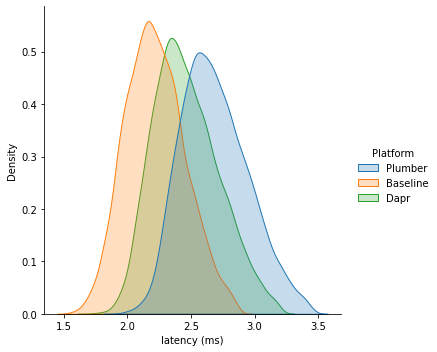

In [26]:
sns.displot(filtered_df, x="latency (ms)", hue="Platform", kind="kde", fill=True)

<AxesSubplot:xlabel='latency (ms)', ylabel='Proportion'>

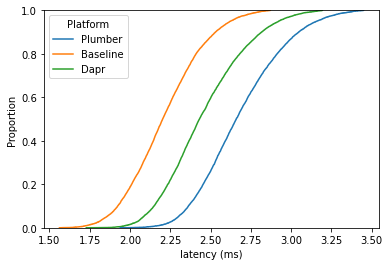

In [28]:
sns.ecdfplot(data=filtered_df, x="latency (ms)", hue="Platform")

In [54]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in filtered_df["Platform"].unique():
    plat_df = filtered_df[filtered_df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["latency (ms)"]}, ignore_index=True) 

In [55]:
df_metrics.head()

,Metric,Platform,Latency (ms)
0,Median,Plumber,2.659590
1,90th Percentile,Plumber,3.046926
2,99th Percentile,Plumber,3.344374
3,Median,Baseline,2.202637
4,90th Percentile,Baseline,2.530617


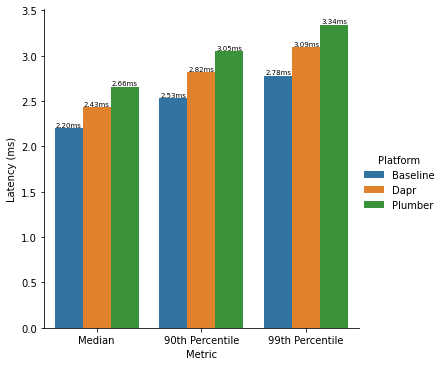

In [69]:
g = sns.catplot(
    data=df_metrics, kind="bar",
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=["Baseline", "Dapr", "Plumber"]
)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}ms' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', fontsize='x-small')